In [11]:
# !pip install seaborn


In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.stats as stats

In [13]:
# Set up files
dir_firstSess = 'data/corr_firstSess'
files_firstSess = [f for f in os.listdir(dir_firstSess) if f.endswith('.csv')]

dir_secondSess = 'data/corr_secondSess'
files_secondSess = [f for f in os.listdir(dir_secondSess) if f.endswith('.csv')]

numTotalSessions = len(files_firstSess) + len(files_secondSess)

print('Number of total sessions: ', numTotalSessions)
print('Number of subjects who completed the second session: ', len(files_secondSess))

Number of total sessions:  7
Number of subjects who completed the second session:  3


# Data cleaning
## Check if all experiments are completed

In [14]:
def checkIfComplete(mydir, files):
    
    numSess = len(files)
    
    for sess in range(numSess):

        # Read the CSV file
        file_path = os.path.join(mydir, files[sess])
        mainOutput = pd.read_csv(file_path)

        # Exclusion criteria 1: experiment completed
        complete_val = mainOutput['experimentCompleteBool'].dropna().iloc[0]
        complete_bool = str(complete_val) == 'True'
        if not complete_bool:
            prolificID = mainOutput['ProlificParticipantID'].dropna().iloc[0]
            print(f'Warning: incomplete experiment (session: {sess})')
            
    print(f'Completion check completed! ({numSess} files total)')
                        

In [15]:
checkIfComplete(dir_firstSess, files_firstSess)

Completion check completed! (4 files total)


In [16]:
checkIfComplete(dir_secondSess, files_secondSess)

Completion check completed! (3 files total)


## Acquire thresholds for all tasks

### Functions:

In [17]:
def getThresholds(mydir, files, condition_names, num_trials_per_staircase=35):
    
    all_data = []
    
    numSess = len(files)
    numThresholdsCat = len(condition_names)
    
    for sess in range(numSess):

        # Read the CSV file
        file_path = os.path.join(mydir, files[sess])
        mainOutput = pd.read_csv(file_path)
        subj_logThresholds = {}
                
        prolificID = mainOutput['ProlificParticipantID'].dropna().iloc[0]
        subj_logThresholds['prolificID'] = prolificID
                
        for cat in range(numThresholdsCat):
            
            condition_name = condition_names[cat]
                        
            condition_data = mainOutput[mainOutput['conditionName'] == condition_name]
                        
            # number of trials sent to quest
            # Count trials sent to quest
            trial_sent = condition_data['trialGivenToQuest']           
            num_trial_sent = sum(str(this_trial) == 'True' for this_trial in trial_sent)
            num_trial_not_sent = sum(str(this_trial) == 'False' for this_trial in trial_sent)
            trial_sent_bool = num_trial_sent >= num_trials_per_staircase
            num_missing_line = sum(trial_sent.isna())

            if not trial_sent_bool:
                # print(files[sess])
                print(f'Warning1: not enough trials (Session {sess}, condition {condition_name})')
                print(f'Num total trials: {len(trial_sent) - 1}')
                print(f'Num trials missing: {num_trials_per_staircase - num_trial_sent}')
                print(f'Num trials marked as not sent: {num_trial_not_sent}')
                print(f'Num lines missing: {num_missing_line - 1}')


            # questSD > 0.1
            questSD = condition_data['questSDAtEndOfTrialsLoop'].dropna().iloc[0]
            small_questSD_bool = questSD < 0.1
            if not small_questSD_bool:
                print(f'Warning2: large SD (Session {sess}, condition {condition_name})')
                
                
            assert(len(condition_data.questMeanAtEndOfTrialsLoop.dropna()) == 1)

            subj_logThresholds[condition_name] = condition_data.questMeanAtEndOfTrialsLoop.dropna().iloc[0]
#             if not small_questSD_bool:
#                 print(f'Warning: large SD (Session {sess}, condition {condition_name})')
            
#             if trial_sent_bool and small_questSD_bool:
#                 # check that only 1 threshold is reported for this condition
#                 assert(len(condition_data.questMeanAtEndOfTrialsLoop.dropna()) == 1)

#                 subj_logThresholds[condition_name] = condition_data.questMeanAtEndOfTrialsLoop.dropna().iloc[0]
                
#             else:
#                 subj_logThresholds[condition_name] = np.nan
            
        
        all_data.append(subj_logThresholds)
        
        all_data_df = pd.DataFrame(all_data)
        
    return all_data_df
            


In [18]:
def getRSVPThresholds(mydir, files, condition_names, num_trials_per_staircase=24):
    
    all_data = []
    
    numSess = len(files)
    numThresholdsCat = len(condition_names)
    
    for sess in range(numSess):

        # Read the CSV file
        file_path = os.path.join(mydir, files[sess])
        mainOutput = pd.read_csv(file_path)
        subj_wpm = {}
                
        prolificID = mainOutput['ProlificParticipantID'].dropna().iloc[0]
        subj_wpm['prolificID'] = prolificID
                
        for cat in range(numThresholdsCat):
            
            condition_name = condition_names[cat]
                        
            condition_data = mainOutput[mainOutput['conditionName'] == condition_name]
                        
            # number of trials sent to quest
            # Count trials sent to quest
            trial_sent = condition_data['trialGivenToQuest']           
            num_trial_sent = sum(str(this_trial) == 'True' for this_trial in trial_sent)
            num_trial_not_sent = sum(str(this_trial) == 'False' for this_trial in trial_sent)
            trial_sent_bool = num_trial_sent >= num_trials_per_staircase
            num_missing_line = sum(trial_sent.isna())

            if not trial_sent_bool:
                # print(files[sess])
                print(f'Warning1: not enough trials (Session {sess}, condition {condition_name})')
                print(f'Num total trials: {len(trial_sent) - 1}')
                print(f'Num trials missing: {num_trials_per_staircase - num_trial_sent}')
                print(f'Num trials marked as not sent: {num_trial_not_sent}')
                print(f'Num lines missing: {num_missing_line - 1}')

            # questSD > 0.1
            questSD = condition_data['questSDAtEndOfTrialsLoop'].dropna().iloc[0]
            small_questSD_bool = questSD < 0.1
            if not small_questSD_bool:
                print(f'Warning2: large SD (Session {sess}, condition {condition_name})')
            
#             if trial_sent_bool and small_questSD_bool:
#                 # check that only 1 threshold is reported for this condition
#                 assert(len(condition_data.questMeanAtEndOfTrialsLoop.dropna()) == 1)

#                 thresholds_raw_log = condition_data.questMeanAtEndOfTrialsLoop.dropna().iloc[0]
                
#                 subj_wpm[condition_name] = np.power(10, np.log10(60) - thresholds_raw_log)
                
#             else:
#                 subj_wpm[condition_name] = np.nan

            assert(len(condition_data.questMeanAtEndOfTrialsLoop.dropna()) == 1)

            thresholds_raw_log = condition_data.questMeanAtEndOfTrialsLoop.dropna().iloc[0]
            subj_wpm[condition_name] = np.power(10, np.log10(60) - thresholds_raw_log)

            
        
        all_data.append(subj_wpm)
        
        all_data_df = pd.DataFrame(all_data)
        
    return all_data_df
        

In [19]:
def getOrdReadingSpeed(mydir, files, condition_dict):
    
    condition_names = list(condition_dict.keys())
    
    all_data = []
    
    numSess = len(files)
    numThresholdsCat = len(condition_names)
    
    for sess in range(numSess):
        
        # Read the CSV file
        file_path = os.path.join(mydir, files[sess])
        mainOutput = pd.read_csv(file_path)
        subj_wpm = {}
                
        prolificID = mainOutput['ProlificParticipantID'].dropna().iloc[0]
        subj_wpm['prolificID'] = prolificID
        
        for cat in range(numThresholdsCat):
            
            condition_name = condition_names[cat]

            # Check if the participant answered 3 or more questions correctly
            question_labels = condition_dict[condition_name]
            num_questions = len(question_labels)
            question_correct_bool = np.full(num_questions,np.nan)
            for qq in range(num_questions):

                qq_data = mainOutput[mainOutput['questionAndAnswerNickname'] == question_labels[qq]]
                
                question_correct_bool[qq] = (qq_data['questionAndAnswerCorrectAnswer'].item() == qq_data['questionAndAnswerResponse'].item())
                
            percent_correct = sum(question_correct_bool) / num_questions * 100 
            
            
            if percent_correct >= 0: #60
            
                speed_data = mainOutput[mainOutput['conditionName'] == condition_name]
                
                numWords = speed_data['readingPageWords'].dropna()
                reading_time = speed_data['readingPageDurationOnsetToOffsetSec'].dropna()
                pg_wordsPerMin = numWords / (reading_time / 60)
                include_wordsPerMin = pg_wordsPerMin[1:len(pg_wordsPerMin)-1] # exclude first and last page
                subj_wpm[condition_name] = np.mean(include_wordsPerMin)
            
            else:
                
                print(f'Warning: percent correct is too low: session {sess}, passage {cat}')
                subj_wpm[condition_name] = np.nan
                
                
    
                
        all_data.append(subj_wpm)
        
        all_data_df = pd.DataFrame(all_data)
        
    return all_data_df
            
        

### Acquire thresholds:

- Note that data acquired for RSVP and Ordinary reading are in words per min -- not logged

- All the other thresholds are logged

- As of March 16th, I'm not excluding any data, as we only have a few participants and somehow excluding data based on our exclusion criteria excludes too much data. The codes are ready for excluding data based on our pre-determined exclusion criteria; we can exclude data once we get more participants.

In [20]:
# first session

thresholds_names_sess1 = ['crowding_R8_block1','crowding_L8_block1',
                          'crowding_R8_block2','crowding_L8_block2',
                          'vernier_R8_block1','vernier_L8_block1',
                          'acuity_R8_block1','acuity_L8_block1']
df_firstSess = getThresholds(dir_firstSess, files_firstSess, thresholds_names_sess1)

thresholds_rsvp_sess1 = ['rsvp_foveal_block1']
df_firstSess_rsvp = getRSVPThresholds(dir_firstSess, files_firstSess, thresholds_rsvp_sess1)

thresholds_names_read1 = {
        'reading_Beaver_block1': ['Beaver_1','Beaver_2','Beaver_3','Beaver_4','Beaver_5'],
        'reading_Winter_block2': ['Winter_1','Winter_2','Winter_3','Winter_4','Winter_5']}
df_firstSess_reading = getOrdReadingSpeed(dir_firstSess, files_firstSess, thresholds_names_read1)

Warning1: not enough trials (Session 0, condition crowding_R8_block1)
Num total trials: 35
Num trials missing: 20
Num trials marked as not sent: 0
Num lines missing: 20
Warning1: not enough trials (Session 0, condition crowding_L8_block1)
Num total trials: 35
Num trials missing: 20
Num trials marked as not sent: 0
Num lines missing: 20
Warning1: not enough trials (Session 0, condition crowding_R8_block2)
Num total trials: 35
Num trials missing: 1
Num trials marked as not sent: 0
Num lines missing: 1
Warning1: not enough trials (Session 0, condition crowding_L8_block2)
Num total trials: 35
Num trials missing: 1
Num trials marked as not sent: 0
Num lines missing: 1
Warning1: not enough trials (Session 0, condition vernier_R8_block1)
Num total trials: 35
Num trials missing: 2
Num trials marked as not sent: 0
Num lines missing: 2
Warning2: large SD (Session 0, condition vernier_R8_block1)
Warning1: not enough trials (Session 0, condition vernier_L8_block1)
Num total trials: 35
Num trials m

In [21]:
# second session

thresholds_names_sess2 = ['crowding_R8_block3','crowding_L8_block3',
                          'crowding_R8_block4','crowding_L8_block4',
                          'vernier_R8_block2','vernier_L8_block2',
                          'acuity_R8_block2','acuity_L8_block2']
df_secondSess = getThresholds(dir_secondSess, files_secondSess, thresholds_names_sess2)

thresholds_rsvp_sess2 = ['rsvp_foveal_block2']
df_secondSess_rsvp = getRSVPThresholds(dir_secondSess, files_secondSess, thresholds_rsvp_sess2)

thresholds_names_read2 = {
        'reading_Desert_block1': ['Desert_1','Desert_2','Desert_3','Desert_4','Desert_5'],
        'reading_Islands_block2': ['Islands_1','Islands_2','Islands_3','Islands_4','Islands_5']}

df_secondSess_reading = getOrdReadingSpeed(dir_secondSess, files_secondSess, thresholds_names_read2)


Warning2: large SD (Session 0, condition vernier_R8_block2)
Warning2: large SD (Session 0, condition vernier_L8_block2)
Warning2: large SD (Session 1, condition vernier_R8_block2)
Warning2: large SD (Session 1, condition vernier_L8_block2)
Warning2: large SD (Session 2, condition vernier_R8_block2)
Warning2: large SD (Session 2, condition vernier_L8_block2)
Warning1: not enough trials (Session 2, condition acuity_L8_block2)
Num total trials: 35
Num trials missing: 1
Num trials marked as not sent: 0
Num lines missing: 1


In [22]:
# merge data frames

df_first_merge = pd.merge(df_firstSess, df_firstSess_rsvp, on="prolificID", how="inner")
df_first = pd.merge(df_first_merge, df_firstSess_reading, on="prolificID", how="inner")

df_second_merge = pd.merge(df_secondSess, df_secondSess_rsvp, on="prolificID", how="inner")
df_second = pd.merge(df_second_merge, df_secondSess_reading, on="prolificID", how="inner")


df_both_sessions = pd.merge(df_first, df_second, on="prolificID", how="inner")
display(df_both_sessions)

,prolificID,crowding_R8_block1,crowding_L8_block1,crowding_R8_block2,crowding_L8_block2,vernier_R8_block1,vernier_L8_block1,acuity_R8_block1,acuity_L8_block1,rsvp_foveal_block1,...,crowding_L8_block3,crowding_R8_block4,crowding_L8_block4,vernier_R8_block2,vernier_L8_block2,acuity_R8_block2,acuity_L8_block2,rsvp_foveal_block2,reading_Desert_block1,reading_Islands_block2
0,678e3a87ebf71a02ac3e0863,0.176029,-0.058019,0.408626,0.008331,1.825692,1.868695,-0.521041,-0.470285,887.853852,...,0.038981,0.179518,0.242929,1.822005,1.798552,-0.426252,-0.471158,814.104174,965.752622,1325.192635
1,67605fd17b8d0f9f103620fd,0.548257,0.637828,0.198166,-0.071300,-1.336578,-1.441726,-0.573059,-0.573378,2507.794389,...,0.212469,0.284413,0.466494,-0.971274,-1.167052,-0.674468,-0.573490,1940.794597,118.837009,1500.862299
2,60721c2da01b3a616edba9a7,0.345822,0.561706,0.331428,0.010876,-0.725028,-0.655536,-0.470873,-0.557858,1003.302223,...,0.515543,0.309817,0.372378,-1.015131,-1.032828,-0.428541,-0.533828,907.148161,262.477838,281.121791


## Examine crowding thresholds

In [23]:
dfs = [df_first, df_second]

crowding_data = []

for df in dfs:
    crowding_columns = [col for col in df.columns if col.startswith("crowding")]
    crowding_values = df[crowding_columns].values.flatten()
    crowding_data.extend(crowding_values)

crowding_array = np.array(crowding_data)

eccentricity = 8
bouma = 10 ** crowding_array / eccentricity

print(bouma)

[0.18747311 0.10936824 0.3202844  0.12742089 0.22863933 0.70485907
 0.15470337 0.45028466 0.4417404  0.54292296 0.19727677 0.10607423
 0.27716125 0.45563393 0.26812571 0.12816999 0.33846112 0.13673859
 0.1889853  0.21869528 0.25630776 0.20388183 0.24061537 0.36593533
 0.18040288 0.40968776 0.25510972 0.29463739]


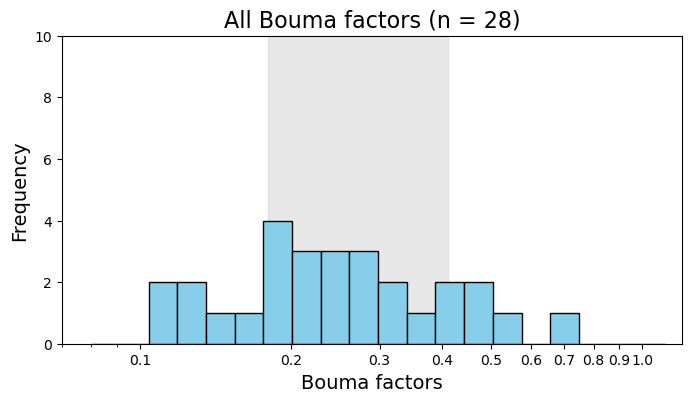

In [24]:
# Plot all bouma factors

# make the bins look the same size on a log scale
num_bins = 20
# min_val = round(np.nanmin(bouma),2)
# max_val = round(np.nanmax(bouma),2)
# print(f'Min and max bin limits: {min_val}, {max_val}')
# bins = np.logspace(np.log10(min_val), np.log10(max_val), num_bins + 1)
min_val = 0.08
max_val = 1.11
bins = np.logspace(np.log10(min_val), np.log10(max_val), num_bins + 1)
lowerBound = 0.18
upperBound = 0.41

plt.figure(figsize=(8, 4))  # Square figure
plt.axvspan(lowerBound, upperBound, color='lightgray', alpha=0.5) # mean +- one std
plt.hist(bouma, bins=bins, color='skyblue', edgecolor='black')
plt.title(f"All Bouma factors (n = {len(bouma)})", fontsize = 16)
plt.xlabel("Bouma factors", fontsize = 14)
plt.ylabel("Frequency", fontsize = 14)
plt.xscale('log')
plt.xlim(0.07,1.2)
plt.ylim(0,10)
# add ticks and format them as normal floats
tick_positions = np.linspace(0.1, 1, num=10)  
plt.xticks(tick_positions, labels=[f"{x:.1f}" for x in tick_positions])


plt.show()

# Analysis

### Test-retest

In [25]:
df_both_sessions['crowding_R8_12'] = (df_both_sessions['crowding_R8_block1'] + 
                                      df_both_sessions['crowding_R8_block2']) / 2

df_both_sessions['crowding_L8_12'] = (df_both_sessions['crowding_L8_block1'] + 
                                      df_both_sessions['crowding_L8_block2']) / 2

df_both_sessions['crowding_R8_34'] = (df_both_sessions['crowding_R8_block3'] + 
                                      df_both_sessions['crowding_R8_block4']) / 2

df_both_sessions['crowding_L8_34'] = (df_both_sessions['crowding_L8_block3'] + 
                                      df_both_sessions['crowding_L8_block4']) / 2

In [26]:
df_both_sessions['ordreading_sess1'] = 10 ** ((np.log10(df_both_sessions['reading_Beaver_block1']) + 
                                               np.log10(df_both_sessions['reading_Winter_block2'])) / 2)

df_both_sessions['ordreading_sess2'] = 10 ** ((np.log10(df_both_sessions['reading_Desert_block1']) + 
                                               np.log10(df_both_sessions['reading_Islands_block2'])) / 2)

In [27]:
def plot_scatter_with_correlation(df, var_x, var_y, title, plotXequalsY_bool=False):
    """
    Plots a scatter plot of two variables from a DataFrame and computes Pearson's r.
    
    Parameters:
        df (pd.DataFrame): The data frame containing the variables.
        var_x (str): Name of the first variable (x-axis).
        var_y (str): Name of the second variable (y-axis).
    """
    # Compute Pearson correlation
    r, p_value = stats.pearsonr(df[var_x], df[var_y])
    
    # Determine axis limits (same for both axes)
    min_val = min(df[var_x].min(), df[var_y].min())
    min_val = min_val - abs(min_val) * 0.2
    max_val = max(df[var_x].max(), df[var_y].max())
    max_val = max_val + abs(max_val) * 0.2


    # Create the scatter plot
    plt.figure(figsize=(4, 4))  
    sns.scatterplot(x=df[var_x], y=df[var_y], s=50)

    # plot x = y
    if plotXequalsY_bool:
            plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", linewidth=1.5)
            
    # Set limits for both axes to be the same
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)

    # Add title with Pearson's r value
    plt.title(title + f"\n r = {r:.2f}", fontsize=16)
    
    # Add labels
    plt.xlabel(var_x, fontsize=14)
    plt.ylabel(var_y, fontsize=14)
    plt.xticks(fontsize=10)  
    plt.yticks(fontsize=10) 
    
        
    # Ensure aspect ratio is equal for x and y
    plt.gca().set_aspect('equal', adjustable='box')
    
    # Show plot
    plt.show()


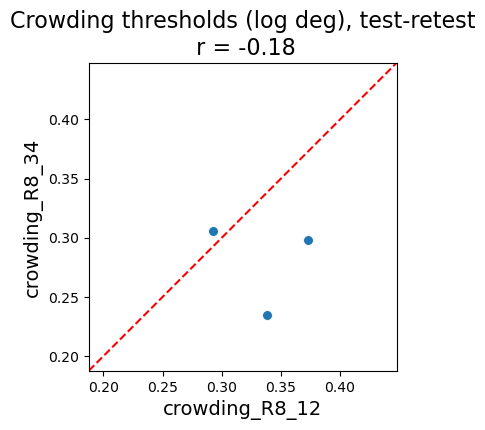

In [28]:
plot_scatter_with_correlation(df_both_sessions, "crowding_R8_12", "crowding_R8_34", 
                              'Crowding thresholds (log deg), test-retest', plotXequalsY_bool=True)


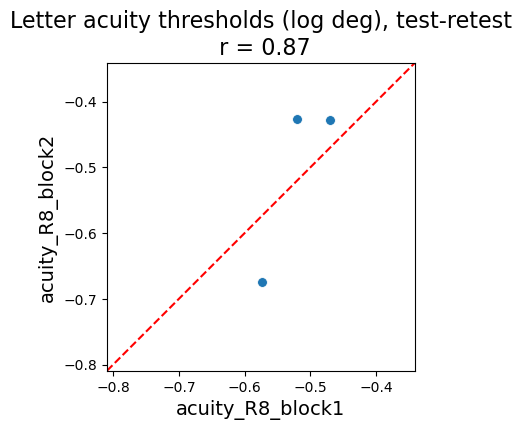

In [29]:
plot_scatter_with_correlation(df_both_sessions, "acuity_R8_block1", "acuity_R8_block2", 
                              'Letter acuity thresholds (log deg), test-retest', plotXequalsY_bool=True)


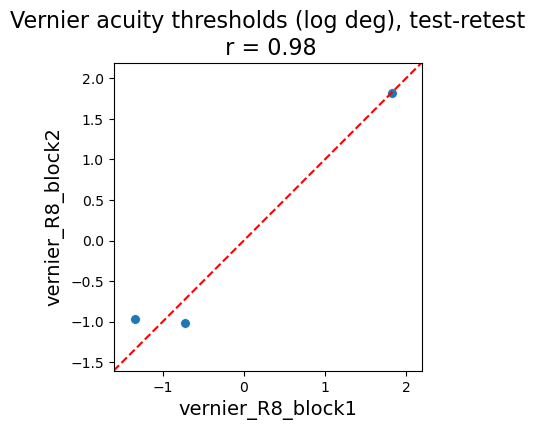

In [30]:
plot_scatter_with_correlation(df_both_sessions, "vernier_R8_block1", "vernier_R8_block2", 
                              'Vernier acuity thresholds (log deg), test-retest', plotXequalsY_bool=True)


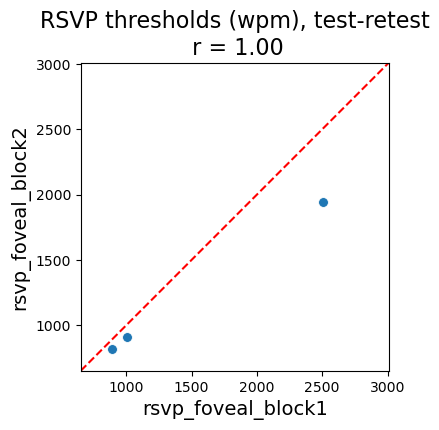

In [31]:
plot_scatter_with_correlation(df_both_sessions, "rsvp_foveal_block1", "rsvp_foveal_block2", 
                              'RSVP thresholds (wpm), test-retest', plotXequalsY_bool=True)


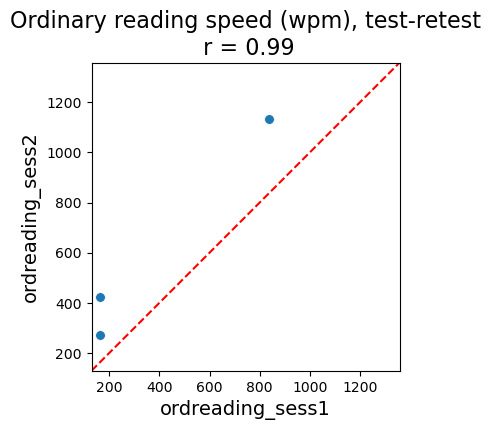

In [32]:
plot_scatter_with_correlation(df_both_sessions, "ordreading_sess1", "ordreading_sess2", 
                              'Ordinary reading speed (wpm), test-retest', plotXequalsY_bool=True)

### Average over repeats for each participant

In [33]:
# average between sessions

subj_avg_thresholds = {}


subj_avg_thresholds['crowding_R8'] = (df_both_sessions['crowding_R8_12'] + 
                                      df_both_sessions['crowding_R8_34']) / 2
subj_avg_thresholds['crowding_L8'] = (df_both_sessions['crowding_L8_12'] + 
                                      df_both_sessions['crowding_L8_34']) / 2
subj_avg_thresholds['crowding_RL'] = (subj_avg_thresholds['crowding_R8'] + 
                                      subj_avg_thresholds['crowding_L8']) / 2

subj_avg_thresholds['acuity_R8'] = (df_both_sessions['acuity_R8_block1'] + 
                                      df_both_sessions['acuity_R8_block2']) / 2
subj_avg_thresholds['acuity_L8'] = (df_both_sessions['acuity_L8_block1'] + 
                                      df_both_sessions['acuity_L8_block2']) / 2
subj_avg_thresholds['acuity_RL'] = (subj_avg_thresholds['acuity_R8'] + 
                                      subj_avg_thresholds['acuity_L8']) / 2

subj_avg_thresholds['vernier_R8'] = (df_both_sessions['vernier_R8_block1'] + 
                                      df_both_sessions['vernier_R8_block2']) / 2
subj_avg_thresholds['vernier_L8'] = (df_both_sessions['vernier_L8_block1'] + 
                                      df_both_sessions['vernier_L8_block2']) / 2
subj_avg_thresholds['vernier_RL'] = (subj_avg_thresholds['vernier_R8'] + 
                                      subj_avg_thresholds['vernier_L8']) / 2

subj_avg_thresholds['rsvp_log'] =  ((np.log10(df_both_sessions['rsvp_foveal_block1']) + 
                                      np.log10(df_both_sessions['rsvp_foveal_block2'])) / 2)

subj_avg_thresholds['ordinary_reading_log'] = ((np.log10(df_both_sessions['ordreading_sess1']) + 
                                               np.log10(df_both_sessions['ordreading_sess2'])) / 2)

df_subj_avg = pd.DataFrame(subj_avg_thresholds)
df_subj_avg.head()

,crowding_R8,crowding_L8,crowding_RL,acuity_R8,acuity_L8,acuity_RL,vernier_R8,vernier_L8,vernier_RL,rsvp_log,ordinary_reading_log
0,0.299193,0.058056,0.178624,-0.473646,-0.470721,-0.472184,1.823849,1.833623,1.828736,2.929511,2.988450
1,0.335672,0.311373,0.323522,-0.623764,-0.573434,-0.598599,-1.153926,-1.304389,-1.229158,3.343636,2.418544
2,0.286600,0.365126,0.325863,-0.449707,-0.545843,-0.497775,-0.870079,-0.844182,-0.857131,2.979555,2.320957


### Is there left-right asymmetry?

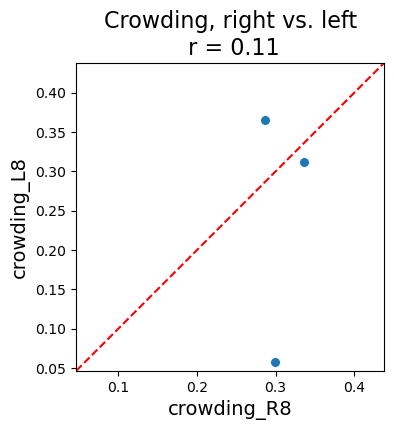

In [34]:
plot_scatter_with_correlation(df_subj_avg, "crowding_R8", "crowding_L8", 
                              'Crowding, right vs. left', plotXequalsY_bool=True)

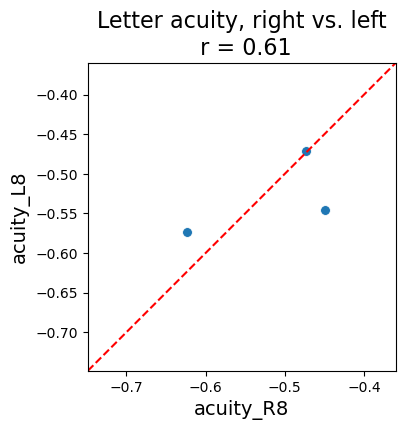

In [35]:
plot_scatter_with_correlation(df_subj_avg, "acuity_R8", "acuity_L8", 
                              'Letter acuity, right vs. left', plotXequalsY_bool=True)

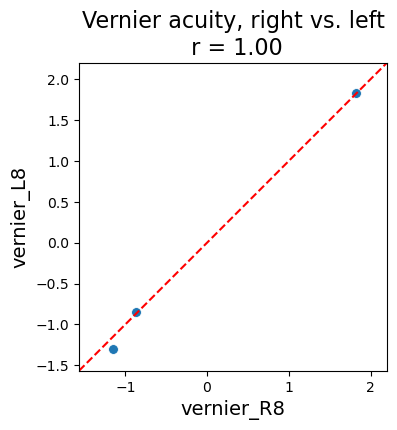

In [36]:
plot_scatter_with_correlation(df_subj_avg, "vernier_R8", "vernier_L8", 
                              'Vernier acuity, right vs. left', plotXequalsY_bool=True)

### Correlation between tasks

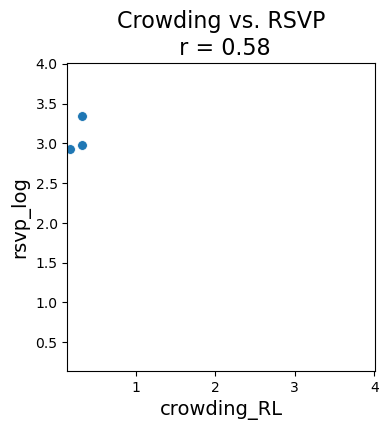

In [37]:
plot_scatter_with_correlation(df_subj_avg, "crowding_RL", "rsvp_log", 
                              'Crowding vs. RSVP')

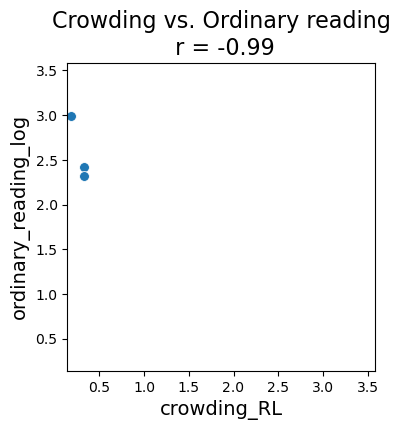

In [38]:
plot_scatter_with_correlation(df_subj_avg, "crowding_RL", "ordinary_reading_log", 
                              'Crowding vs. Ordinary reading')

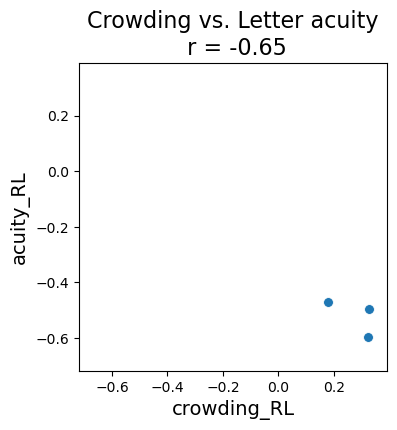

In [39]:
plot_scatter_with_correlation(df_subj_avg, "crowding_RL", "acuity_RL", 
                              'Crowding vs. Letter acuity')

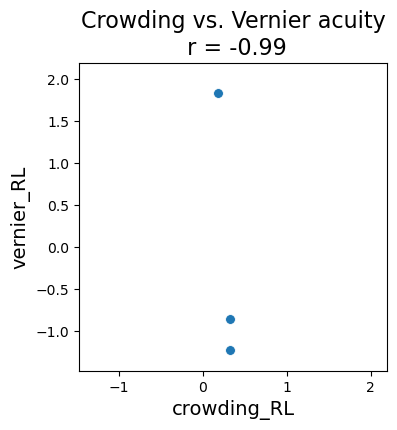

In [40]:
plot_scatter_with_correlation(df_subj_avg, "crowding_RL", "vernier_RL", 
                              'Crowding vs. Vernier acuity')

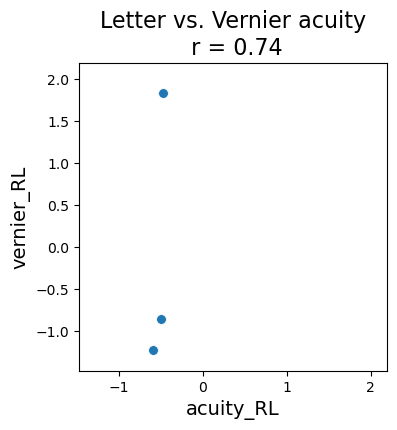

In [41]:
plot_scatter_with_correlation(df_subj_avg, "acuity_RL", "vernier_RL", 
                              'Letter vs. Vernier acuity')